Failed with encoding: utf-8
Successfully loaded with encoding: latin-1
Columns: ['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']
Dataset shape: (16363, 2)
sentiment
positive    8582
negative    7781
Name: count, dtype: int64
Processing texts with SpaCy (batch mode)...
Example cleaned text:
sooo sad miss san diego

Top 20 Positive Words:
day        0.037207
good       0.034288
happy      0.031514
love       0.030327
mothers    0.025965
thanks     0.025492
great      0.018423
hope       0.015439
nice       0.014286
thank      0.013656
fun        0.013584
like       0.013565
morning    0.012667
lol        0.012475
night      0.012014
awesome    0.011795
today      0.010838
wish       0.010759
got        0.010514
haha       0.009982
dtype: float64

Top 20 Negative Words:
miss     0.021766
sad      0.018411
sorry    0.016847
like     0.015714
work     0.015455
bad      0.014088
feel     0.01

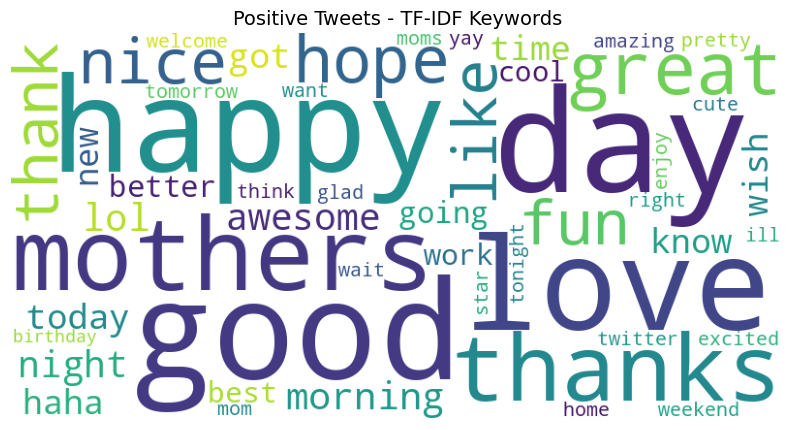

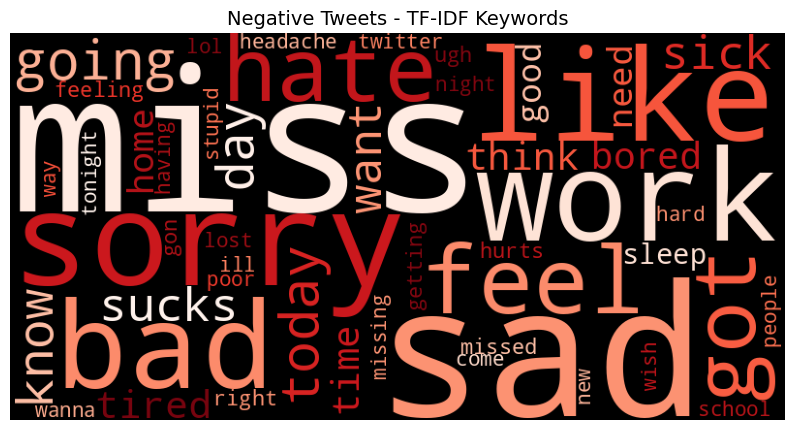

In [ ]:
!pip install scikit-learn wordcloud
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# --- Step 1: Load SpaCy model ---
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# --- Step 2: Safe CSV loading function ---
def safe_read_csv(path):
    """
    Try multiple encodings to safely read CSV files.
    """
    for enc in ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Successfully loaded with encoding: {enc}")
            return df
        except UnicodeDecodeError:
            print(f"Failed with encoding: {enc}")
    raise ValueError("All decoding attempts failed. Please check the file format.")

# Load your dataset
df = safe_read_csv("/content/train.csv")

# --- Step 3: Keep only relevant columns and filter sentiments ---
print("Columns:", df.columns.tolist())

df = df[['text', 'sentiment']].dropna()
df = df[df['sentiment'].isin(['positive', 'negative'])].copy()

print("Dataset shape:", df.shape)
print(df['sentiment'].value_counts())

# --- Step 4: Text cleaning with SpaCy (BATCH PROCESSING) ---
def preprocess_text(text):
    """
    Pre-clean text before SpaCy processing (faster with regex).
    """
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Pre-clean all texts first (fast with regex)
df['preprocessed'] = df['text'].apply(preprocess_text)

# Batch process with SpaCy (MUCH FASTER!)
print("Processing texts with SpaCy (batch mode)...")
docs = list(nlp.pipe(df['preprocessed'], batch_size=500, n_process=1))

# Extract cleaned tokens from processed docs
cleaned_texts = []
for doc in docs:
    tokens = [token.text for token in doc
              if not token.is_stop
              and not token.is_punct
              and len(token.text) > 2
              and token.is_alpha]
    cleaned_texts.append(" ".join(tokens))

df['clean_text'] = cleaned_texts

print("Example cleaned text:")
print(df['clean_text'].iloc[0])

# --- Step 5: TF-IDF vectorization ---
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
feature_names = vectorizer.get_feature_names_out()

# --- Step 6: Compute average TF-IDF per sentiment ---
pos_idx = df['sentiment'] == 'positive'
neg_idx = df['sentiment'] == 'negative'

X_pos = X[pos_idx.values, :]
X_neg = X[neg_idx.values, :]

# Compute mean TF-IDF for each word
pos_mean = np.asarray(X_pos.mean(axis=0)).ravel()
neg_mean = np.asarray(X_neg.mean(axis=0)).ravel()

# Convert to Pandas Series
pos_scores = pd.Series(pos_mean, index=feature_names).sort_values(ascending=False)
neg_scores = pd.Series(neg_mean, index=feature_names).sort_values(ascending=False)

# --- Step 7: Display top words ---
print("\nTop 20 Positive Words:")
print(pos_scores.head(20))

print("\nTop 20 Negative Words:")
print(neg_scores.head(20))

# --- Step 8: Visualization with WordCloud ---
# Positive words
plt.figure(figsize=(10,6))
wc_pos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_scores.head(50).to_dict())
plt.imshow(wc_pos)
plt.axis('off')
plt.title("Positive Tweets - TF-IDF Keywords", fontsize=14)
plt.show()

# Negative words
plt.figure(figsize=(10,6))
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(neg_scores.head(50).to_dict())
plt.imshow(wc_neg)
plt.axis('off')
plt.title("Negative Tweets - TF-IDF Keywords", fontsize=14)
plt.show()